Grid Positions to boolean (velocity and acceleration in real)
Just do repulsive potential for low density 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML # inline video embed
from itertools import combinations

How to:

change n_particles, total_steps and boxsize as required. Specify initial conditions if needed. Currently just randomly generate them (they can overlap initially--this functionality is still being worked on). 

In [32]:
n_particles = 10
time_step = 0.01
total_steps = 1000
boxsize = 50
x_main = np.zeros((total_steps,n_particles,2)) # (x,y) position holders for n particles
v_main = np.zeros((total_steps,n_particles,2))
a_main = np.zeros((total_steps,n_particles,2))

In [33]:
            
x_main[0] = boxsize*np.random.rand(n_particles,2) # scale to boxsize
v_main[0] = 2*np.random.rand(n_particles,2)-1 # random velocity components between [-1, 1)
    

In [34]:
class Simulation():
    def __init__(self, x_main, v_main, a_main):
        self.t_index = 0 # pointer init at start
        self.x_main = x_main
        self.v_main = v_main
        self.a_main = a_main
        
        # l-j potential constants
        self.sigma = 5
        self.epsilon = 1
        self.char_range = 2**(1/6)*self.sigma # minimum in potential
        self.kb = 1
        self.m = 1 # all particles have some mass
        
        # other
        self.wallstiffness = 1
        self.boxsize = 50
        
        # init simulation
        # self.init_particles()
        
    def init_particles(self):
        '''NOT IMPLEMENTED'''
        # setup initial conditions
        def comp_check(a1, a2):
            b = True
            for i in range(len(a1)):
                if a1[i]!=a2[i]:
                    b = False
            return b
        
        for p in range(n_particles):
            x_main[0][p] = boxsize*np.random.rand(1,2) 
            ol_bool = np.ones(n_particles)
            ol_bool[p] = 0 # particle can't overlap upon itself
            check_bool = np.zeros(n_particles) # desired state-> no overlaps
            
            for other_index in range(p): # check overlap against all previous indices
                if not self.overlaps(p, other_index):
                    ol_bool[other_index] = 0
            while not comp_check(ol_bool, check_bool):
                x_main[0][p] = boxsize*np.random.rand(1,2) 
                # reset the overlap check
                ol_bool = np.ones(n_particles)
                ol_bool[p] = 0 # particle can't overlap upon itself
                for other_index in range(p): # check overlap against all previous indices
                    if not self.overlaps(p, other_index):
                        ol_bool[other_index] = 0
        return 0
            

    def updater(self):
        new_values = [self.velocity_verlet(time_step, 
                        x_main[self.t_index][i],
                        v_main[self.t_index][i],
                        a_main[self.t_index][i], 
                        i) for i in range(n_particles)]
       
        # tranpose so the rows are x, v and a and columns
        # are object index
        new_values = np.swapaxes(new_values, 0, 1)

        self.t_index += 1 # increment matrix pointer
        
        
        # check for collisions
        
        # Get a sequence of all of the pairs of particles when
        # we are detecting collisions. combinations generates pairs of indices
        pairs = combinations(range(n_particles), 2)
        for i,j in pairs:
            if self.overlaps(i, j):
                v1, v2 = self.change_velocities(i, j)
                new_values[1][i] = v1
                new_values[1][j] = v2
                
               # new_values[0][i] = # calculate as if it were just at 1
               # new_values[0][j] = new_values[0][i].copy()
                
        # roll over into next row in the main matrices
        x_main[self.t_index] = new_values[0]
        v_main[self.t_index] = new_values[1]
        a_main[self.t_index] = new_values[2]
    
    
    # use verlet algorithm to update velocity as acceleration/force does not depend on velocity
    def velocity_verlet(self, time_step, x_old, v_old, a_old, object_index):
        '''all inputs are vectors except for time_step'''
        x_new = x_old + v_old* time_step + 0.5*a_old * time_step**2
        a_new = self.accel_calc(x_new, object_index)
        
        
        # wall checker
        if x_new[0] < 0: # assume radius 0 
            a_new[0] += self.wallstiffness*(-x_new[0])
        elif x_new[0] > boxsize:
            a_new[0] += self.wallstiffness*(boxsize-x_new[0])
        
        if x_new[1] < 0: # assume radius 0 
            a_new[1] += self.wallstiffness*(-x_new[1])
        elif x_new[1] > boxsize:
            a_new[1] += self.wallstiffness*(boxsize-x_new[1])

    
        # now update vel
        v_new = v_old + 0.5*(a_old+a_new)*time_step
        
        return x_new, v_new, a_new

        
    def accel_calc(self, pos_new, index_this):
       
        # holder
        a = np.zeros(2)
        for i in range(self.x_main.shape[1]): # for each object
            if i==index_this:
                continue # skip itself
            sep_vec = pos_new - x_main[self.t_index][i]
            if np.linalg.norm(sep_vec) < self.char_range: # if in range of repulsive potential
                #print('particle in LJ', i, index_this)
                inv_sep_vec = 1/sep_vec # invert 
                a+= 4*self.epsilon*(6*self.sigma**6*inv_sep_vec**7 - 12*self.sigma**12*inv_sep_vec**13)
        return a
    
    def overlaps(self, this_index, other_index):
        '''checks for overlaps between this particle and any 'other' particle 
        parsed. Does not handle walls. Returns True if there is overlap'''
        return np.hypot(*(x_main[self.t_index][this_index] - x_main[self.t_index][other_index])) < 1
    
    def change_velocities(self, this_index, other_index):
        """
        Particles p1 and p2 have collided elastically: update their
        velocities.
        """
        # masses
        m1, m2 = 1, 1
        M = 2

        # positions
        r1, r2 = x_main[self.t_index][this_index], x_main[self.t_index][other_index]
        d = np.linalg.norm(r1 - r2)**2

        # velocities
        v1, v2 = v_main[self.t_index][this_index], v_main[self.t_index][other_index]

        # new velocity through elastic
        u1 = v1 - 2*m2 / M * np.dot(v1-v2, r1-r2) / d * (r1 - r2)
        u2 = v2 - 2*m1 / M * np.dot(v2-v1, r2-r1) / d * (r2 - r1)

        # set new velocity with restitutions
        return u1, u2

In [35]:
# runner 
sim = Simulation(x_main,v_main,a_main)
for step in range(total_steps-1): # we've already done the first row so we can skip that
    sim.updater()

C:\Users\joshu\Anaconda3\lib\site-packages\ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\joshu\Anaconda3\lib\site-packages\ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in double_scalars


In [41]:
print(x_main[0])
print(a_main[0], a_main[1]) # display initial accelerations vs accelerations in next step. 

[[39.46869555 29.67084813]
 [38.61001063 46.96223681]
 [ 1.38792899 30.40194944]
 [30.89397329 35.09975849]
 [28.50119069 23.06291536]
 [12.98454253 47.65998213]
 [39.90060646 26.79724957]
 [44.55855445 47.71889133]
 [ 7.44840101 21.39848014]
 [46.85207489 49.65264581]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]] [[ 7.84270175e+14 -1.26340700e+04]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [-5.21016597e+14  1.22992928e+04]
 [ 2.40803559e+05  2.21942543e+06]
 [ 0.00000000e+00  0.00000000e+00]
 [-2.42250978e+05 -2.07242563e+06]]


In [37]:
class Animation_main():
    def __init__(self):
        return
    def stepper(self, i):
        # loops through the calculated position trajectories
        current_pos = x_main[4*i]
        self.sc.set_offsets(current_pos)
        return self.sc,
    
    def init(self): # not used
        initial_pos = x_main[0]
        self.sc = self.ax.scatter(initial_pos[:,0], initial_pos[:,1]) # access x,y coords and plot
        return self.sc,
    
    def main(self):
        # animation
        fig, self.ax = plt.subplots()
        self.ax.set_xlim((0,boxsize))
        self.ax.set_ylim((0,boxsize))
        self.ax.set_aspect('equal', 'box')
        initial_pos = x_main[0]
        self.sc = self.ax.scatter(initial_pos[:,0], initial_pos[:,1],marker = 'o') # access x,y coords and plot
        self.ani = animation.FuncAnimation(fig, self.stepper, frames = 250, interval =100, blit=True) # animate all frames
        # in the simulation results
        
        #plt.show()
        # save render
        #Writer = animation.writers['ffmpeg']
        #writer = Writer(fps=15, bitrate=1800)
        #a.ani.save('smi.mp4', writer=writer)

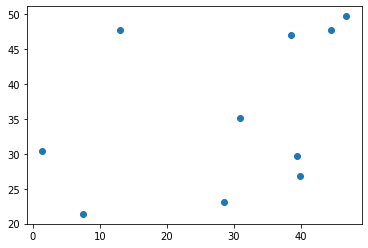

In [39]:
fig, ax = plt.subplots()
#for obj in range(x_main.shape[1]):
#    ax.plot(x_main[:,obj,0],x_main[:,obj,1])
s = 1
ax.scatter(x_main[s,:,0], x_main[s,:,1])
plt.show()

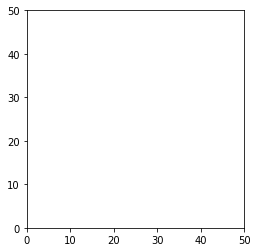

In [159]:
a = Animation_main()
a.main()
HTML(a.ani.to_html5_video()) # convert to embed